In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp data

# Data

> A simple API for importing and preparing data for use. Mostly manipulates numpy arrays to generate profiles and sections
> as well as plane levelling, noise removal and waviness removal/separation. 

In [ ]:
#|hide
from nbdev.showdoc import *


In [ ]:
#note
#Generate a gausspulse for testing?

In [ ]:
#| export
import numpy as np
import imutils
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.ndimage as ndimage
import scipy

In [ ]:
#| hide
from fastcore.test import *

We will be treating 2D arrays as rasters. Basically load any .csv, .txt or other file into a numpy  array as you would normally. Each entry should be the height data for it's respective pixel. 

Let's read an example image using the OpenCV library

In [ ]:
image = np.loadtxt('BYGS008_top_segment_500samp_10cm_interp089.txt')

Let's have a look at the image 

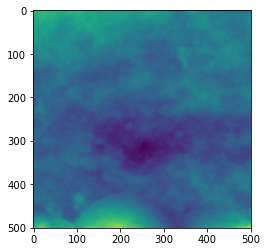

In [ ]:
plt.imshow(image)
plt.show()

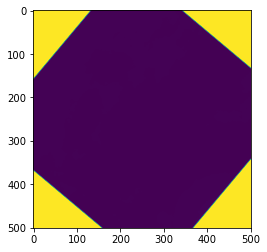

In [ ]:
image_45 = imutils.rotate(image, angle = 50)
plt.imshow(image_45)
plt.show()

In [ ]:
image.shape

(501, 501)

In [ ]:
#| export
def gen_rot_prof(array, #2D array of height values
                     deg = 180, #Number of degrees to rotate through, i.e 180 gives full 360 rotation
                     increment = 1 # indent/180 = number of evenly spaced profiles to calculate.  
                    ):
    ''' Generates an array of rotational profiles through to deg, in even increments of increment. 
    Uses OpenCV and Imutils to rotate the array around the center of the array/raster/image, extracts the middle row. 
    '''
    if deg % increment != 0:
        raise ValueError('Cannot sample evenly, deg % indent must = 0')
    profiles = np.zeros(shape = (deg//increment,array.shape[0]))
    index = 0
    center = array.shape[0]//2  #Center is returned as index to the right of center for even arrays
    for degree in range(0, deg, increment):
        rot_array = imutils.rotate(array, angle = degree)
        profiles[index, :] = rot_array[center,:]
        index += 1
    return profiles
            

Numpy likes the data in various forms for linear algebra, 
here is a helper to convert an (M,N) matrix into a (n,(X,Y,Z)) matrix. 


In [ ]:
#| export
def image2xyz(im):
    '''
    Converts 2D (m,n) image/array to xyz coordinates. Used for plane levelling
    '''
    
    m, n = im.shape
    Y, X = np.mgrid[:m,:n]
    xyz = np.column_stack((X.ravel(),Y.ravel(), im.ravel()))
    
    return xyz

In [ ]:
im_xyz = image2xyz(image)

In order to perform roughness calculations it is recommended to level the data. Here we construct a least-squares solution to the problem, computing the plane results in the same shape as the original image. 

In [ ]:
#| export
def fit_plane(im, # 2D Numpy array or array like 
              to_xyz = True #Convert (m,n) matrix to (n,3) points 
             ):
    '''
    Fits plane to xyz data, returns the computed values over the shape of the original (m,n) image
    '''
    if to_xyz:
        im = image2xyz(im)
    #data = image2xyz(image)
    xs = im[:,0]
    ys = im[:,1]
    zs = im[:,2]
    A = np.c_[xs, ys, np.ones(im.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, zs) #Compute coefficients 
    
    X,Y = np.meshgrid(np.arange(0, np.max(xs)+1, 1), np.arange(0, np.max(ys)+1, 1)) #Grid over ther range of pixel coords
    
    Z = C[0]*X + C[1]*Y + C[2] #Compute values over the grid
    
    return Z 

In [ ]:
w = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
u = np.array([[1,0,-1]]*3)
test_close(w - fit_plane(w), np.zeros(w.shape))
test_close(u - fit_plane(u), np.zeros(u.shape))
test_fail(fit_plane, kwargs = dict(xyz=np.array([1])))
test_fail(fit_plane, kwargs = dict(xyz=np.array([[1,1]])))

In order to level our data we just:

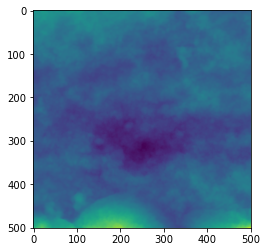

In [ ]:
level_image = image - fit_plane(image)
plt.imshow(level_image)
plt.show()

In [ ]:
def plane_level(im, #Numpy array or array like
                norm = True #Normalize the data by subtracting the mean
               ):
    '''
    Level an (m,n) array by computing the best fit plane and subtracting the results
    '''
    if norm:
        im = im - np.mean(im, axis = None)
    return im - fit_plane(im)

In order to minimize noise we can apply a gaussian filter. 

In [ ]:
#| export
def smooth_image(array, #Numpy array or array like
                 sigma = 1, #Standard deviation for gaussian kernel Useful for determining the wavelength of the low pass filter
                 **kwargs #Keyword arguments for modification of the gaussian_filter function
                ):
    '''
    Removes low frequency/wavelength features ('noise') by applying a gaussian filter on the image. 
    Thin wrapper of scipy.ndimage.gaussian_filter.
    '''
    return ndimage.gaussian_filter(input = array, sigma = sigma, **kwargs)

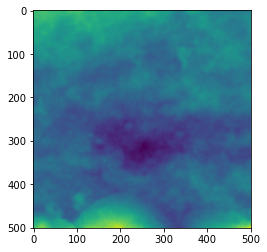

In [ ]:
plt.imshow(smooth_image(image, sigma = 1))
plt.show()

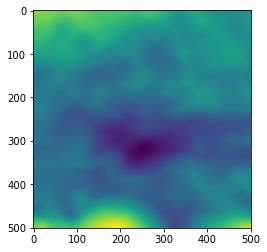

In [ ]:
plt.imshow(smooth_image(image, sigma = 10))
plt.show()

In [ ]:
#| export
def gen_sections(array #2D array (or arraylike) of height values
                ):
    pass
                 

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()